# Deal with Data

## 1. 处理最初的数据集

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

url = '/mnt/data/Project7/fakenews/csv/'
# 将时间局限在事件范围内的所有帖子都取出来.
# 这一步可能需要使用肉眼来观察这个时间的范围
# 可以通过 create_at 这个属性来看到这个帖子的发布时间

In [3]:
df1 = pd.read_csv(url+'13.csv') # or 2.csv 3.csv...取决去topic所选择的时间
# 需要通过 create_at 这个属性来看到这个帖子的发布时间,然后选择出这个时间段的所有数据
# 当然也可以通过最开始 选择限定时间数据集的方法来限定时间

/home/shiqian/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (25,27,28,29,31,39,41,42,43,49,65,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
df1.loc[:2022493, ['created_at']]

,created_at
0,2020-08-30T23:59:59.000Z
1,2020-08-30T23:59:59.000Z
2,2020-08-30T23:59:59.000Z
3,2020-08-30T23:59:59.000Z
4,2020-08-30T23:59:59.000Z
...,...
2022489,2020-08-18T00:00:01.000Z
2022490,2020-08-18T00:00:00.000Z
2022491,2020-08-17T23:59:57.000Z
2022492,2020-08-17T23:59:56.000Z


In [27]:
df1 = df1.iloc[:2022490] # 这里是将时间限定在一定范围内

In [28]:
df4 = pd.read_csv(url+'16.csv')

/home/shiqian/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (25,27,28,29,31,39,41,42,43,49,65,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [56]:
df4.loc[4048018:, ['created_at']]

,created_at
4048018,2021-01-21T00:00:01.000Z
4048019,2021-01-21T00:00:00.000Z
4048020,2021-01-20T23:59:59.000Z
4048021,2021-01-20T23:59:59.000Z
4048022,2021-01-20T23:59:58.000Z
...,...
8073864,2020-12-19T00:00:03.000Z
8073865,2020-12-19T00:00:02.000Z
8073866,2020-12-19T00:00:01.000Z
8073867,2020-12-19T00:00:00.000Z


In [57]:
df4 = df4.iloc[4048020:] # 这里是将时间限定在一定范围内

In [40]:
# 选择出相应的人群
high = pd.read_csv('data/up_points.csv',index_col=0)['Id'].to_list()
low = pd.read_csv('data/low_points.csv',index_col=0)['Id'].to_list()

In [29]:
def filter_data_by_users(df:pd.DataFrame, userlist: list ,title:str):
    """
    df: 为限定完时间段的数据集
    userlist: 为峰的user名单
    title: 命名名单,保存为 'users[title]][alltweets].csv'
    """
    df = df[df['author.username'].isin(userlist)]
    df = df[['id','conversation_id','author.username','referenced_tweets.replied_to.id','referenced_tweets.retweeted.id','referenced_tweets.quoted.id','text']]
    # df.to_csv(f'users[{title}]][alltweets].csv')
    return df

def filter_author_tweet(df:pd.DataFrame) -> pd.DataFrame:
    """
    筛选出users们中texts中, 其中他们发布的帖子
    返回其发帖的dataframe
    """
    df_only_author = df[df['referenced_tweets.retweeted.id'].isna()]
    df_only_author = df_only_author[df_only_author['referenced_tweets.quoted.id'].isna()]
    df_only_author = df_only_author[df_only_author['referenced_tweets.replied_to.id'].isna()]
    return df_only_author

def filter_url(df:pd.DataFrame) -> pd.DataFrame:
    """
    对其发帖中的url进行处理, 删去其中的url
    """
    def wordopt(text):
        text = text.lower()
        # text = re.sub('\\n', '', text) # 删除换行符
        # text = re.sub('\[.*?\]', '', text) # 去掉中括号括起来的字符串
        text = re.sub('https?://\S+|www\.\S+', '', text) # 去掉网址
        # text = re.sub("\\W"," ",text) # 去掉非单词字符
        # text = re.sub('<.*?>+', '', text) # 去掉HTML, XML标签
        # text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # 将文本中所有标点符号删除
        # text = re.sub('\n', '', text) # 删除换行符
        # text = re.sub('\w*\d\w*', '', text) # 删除字母数字混合的“单词”
        return text
    
    df['text'] = df.text.apply(lambda x : wordopt(x))
    return df

def agg_text(df:pd.DataFrame, title:str) -> pd.DataFrame:
    """
    对其中的文本进行合并操作,
    title: 用于命名csv文件
    """
    user_texts = df.groupby(by='author.username').agg(text=("text", lambda x: "\n".join(set(x))))
    user_texts.reset_index(drop=False, inplace=True)
    user_texts.to_csv(f"all_tweet_user[{title}][agg].csv", index=False)
    return user_texts

def filter_data(df:pd.DataFrame, title:str, userlist:list) -> pd.DataFrame:
    df = filter_data_by_users(df, userlist, title)
    df = filter_author_tweet(df)
    df = filter_url(df)
    df = agg_text(df, title)
    return df

In [58]:
user_list = high.copy()
user_list.extend(low)
df1 = filter_data_by_users(df1, user_list, 'all')
df4 = filter_data_by_users(df4, user_list, 'all')
data_list = [df1]
for i in range(14, 15+1):
    df_t = pd.read_csv(url+str(i)+'.csv')
    df_t = filter_data_by_users(df_t, user_list, 'all')
    data_list.append(df_t)
data_list.append(df4)
data_list.reverse()
df = pd.concat(data_list, axis=0)

/home/shiqian/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (25,27,28,29,31,39,41,42,43,65,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [59]:
high_df = filter_data(df, 'top', high)
low_df = filter_data(df, 'low', low)

# Similarity Calculate

## 计算相似度

In [60]:
import os
# 为 jupter notebook 设置系统代理
# 否则可能无法连接到huggingface
proxy = 'http://192.168.50.182:7890'
os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
# 查看是否有可用的gpu加速, 获取gpu的数量
print(torch.cuda.is_available(), torch.cuda.device_count())

True 1


In [61]:
from sentence_transformers import SentenceTransformer  # https://www.sbert.net/
import numpy as np

# 使用时会自动下载所需要的模型.  
# https://huggingface.co/BAAI/bge-large-en-v1.5
model = SentenceTransformer('BAAI/bge-large-en-v1.5', device='cuda')

def embedding(texts: 'list[str]') -> np.ndarray:
    """
    embedding获得text的list,
    并将每一个text进行embedding操作,
    返回每一个text的embedding结果.
    """
    embeddings = model.encode(texts, normalize_embeddings=True)
    return embeddings

def calculateSimilarity(a:np.ndarray, b:np.ndarray) -> np.ndarray:
    """
    计算两个embedding结果之间的相似度,以ndarray的形式输入,返回一个矩阵,表明其之间的相似度
    """
    return a @ b.T

In [62]:
# 测试样例.
# 在python 3.9.18 版本上能够成功使用. （3.7.16也可以）
text1 = ['sample1', 'sample2']
text2 = ['sample3', 'sample4']
embedding1 = embedding(text1)
embedding2 = embedding(text2)
print(embedding1)
print(embedding1 @ embedding2.T)

[[ 0.01565036  0.03648352  0.01993618 ... -0.00103826 -0.00561562
  -0.03185155]
 [ 0.00716442  0.04983097  0.04704395 ... -0.02127947 -0.0060233
  -0.01915274]]
[[0.82828635 0.83361506]
 [0.85577554 0.85415757]]


In [63]:
pd.read_csv("up_point_messages[all][agg].csv").value_counts(['text']).head(1)

text                                                                                                                                                                                                                                           
the daily caller is lying. trump was specifically referring to a white nationalist invasion of the charlottesville community.\n\ndon't take my word: video/transcript here:  real problem is that the daily caller is a facebook fact-checker.     163
dtype: int64

In [65]:
pd.read_csv("low_point_messages[all][agg].csv").value_counts(['text']).head(1)

text                                                                                                         
white house was warned giuliani was target of russian intelligence operation to feed misinformation to trump     603
dtype: int64

In [66]:
# 取出top点的text内容
# 根据实际内容
top_text = "the daily caller is lying. trump was specifically referring to a white nationalist invasion of the charlottesville community.\n\ndon't take my word: video/transcript here:  real problem is that the daily caller is a facebook fact-checker."

low_text = """
white house was warned giuliani was target of russian intelligence operation to feed misinformation to trump
"""

In [67]:
def alltexts_embedding_batches(all_text_path:str, topic:str):
    """
    输入一个user_text的目录,计算其关于topic的相关性大小
    """
    df_all_texts = pd.read_csv(all_text_path)
    all_texts = df_all_texts.text.to_list()
    names = df_all_texts['author.username'].to_list()
    
    # 将其拆分为100个子数组
    texts_batches = np.array_split(all_texts, 100)
    # 为了这个进度条?
    texts_batches = tqdm(texts_batches)
    all_texts_embedding = []
    for batch in texts_batches:
        batch_embedding = embedding(batch)
        all_texts_embedding += batch_embedding.tolist()

    all_texts_embedding = np.array(all_texts_embedding)
    topics_embedding = embedding([topic])
    similarity = calculateSimilarity(all_texts_embedding,topics_embedding)
    return similarity, names

In [68]:
def draw_and_calculate(path:str, topic:str, title:str):
    """
    计算并且绘图
    """
    similarity, names= alltexts_embedding_batches(path, topic)
    fig = plt.figure(figsize=(10,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    bins = [i for i in np.arange(0.3,0.8,0.01)]

    for i in range(len(similarity.T)):
        ax = fig.add_subplot(1, 1, i+1)
        ax.set_title(title)
        ax.hist(similarity.T[i], bins)
    
    return similarity, names

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


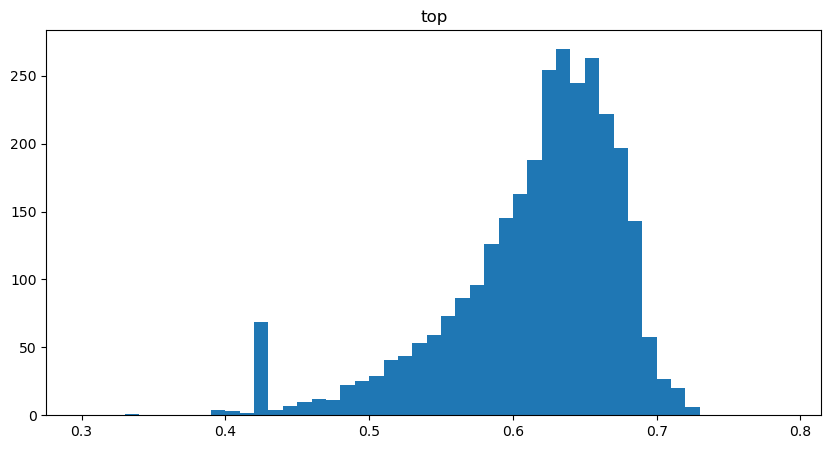

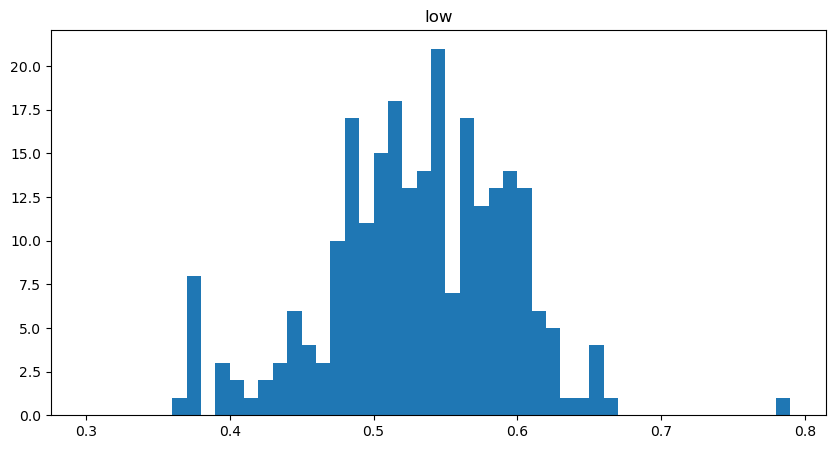

In [69]:
similarity_top, names_top = draw_and_calculate('all_tweet_user[top][agg].csv',top_text,'top')
similarity_low, names_low = draw_and_calculate('all_tweet_user[low][agg].csv',low_text,'low')

## 筛去0.5以下的用户
similarity 与 用户一一对应

In [70]:
def filter_users(similarity, names, min:float) -> list:
    """
    筛选出similarity > min的人群
    """
    ret = []
    for i in tqdm(range(len(names))):
        if similarity.T[0][i] > min:
            ret.append(names[i])
    return ret

In [71]:
names_top_filter = filter_users(similarity_top,names_top, 0.5)
names_low_filter = filter_users(similarity_low,names_low, 0.5)

100%|██████████| 247/247 [00:00<00:00, 408514.62it/s]


In [72]:
print(len(names_low),len(names_low_filter),len(names_top),len(names_top_filter))

247 176 2978 2808


In [4]:
# 下面去掉
100 * ((247 - 176) / 1419)

5.003523608174771

In [5]:
# 上面去掉
100 * ((2978 - 2808) / 9110)

1.8660812294182216